In [ ]:
import os
import cv2
import numpy as np
import shutil
from pathlib import Path
from sklearn.cluster import MiniBatchKMeans
from skimage import feature, exposure
import matplotlib.pyplot as plt
from tqdm import tqdm
import cupy as cp 
import numba
from numba import cuda

try:
    import cupy as cp
    CUDA_AVAILABLE = True
    print("CUDA acceleration available - using GPU")
except ImportError:
    CUDA_AVAILABLE = False
    print("CUDA not available - using CPU only")

class GestureDataFilter:
    """
    GPU-optimized class for filtering and selecting the most important images
    from hand gesture dataset folders. Compatible with RTX 2050.
    """
    
    def __init__(self, data_path, output_path, target_count=50):
        self.data_path = Path(data_path)
        self.output_path = Path(output_path)
        self.target_count = target_count
        self.output_path.mkdir(exist_ok=True, parents=True)
        
    def calculate_image_quality_score(self, image_path):
        """
        Calculate a comprehensive quality score for a grayscale image.
        Optimized for performance with GPU acceleration where possible.
        """
        try:
            img = cv2.imread(str(image_path), cv2.IMREAD_GRAYSCALE)
            if img is None:
                return 0
            
            if CUDA_AVAILABLE:
                return self._calculate_quality_gpu(img)
            else:
                return self._calculate_quality_cpu(img)
                
        except Exception as e:
            print(f"Error processing {image_path}: {e}")
            return 0
    
    def _calculate_quality_cpu(self, img):
        """CPU implementation of quality calculation"""
        focus_score = cv2.Laplacian(img, cv2.CV_64F).var()
        
        contrast_score = np.std(img)
        
        brightness = np.mean(img)
        brightness_score = 1 - abs(brightness - 127) / 127
        
        edges = feature.canny(img, sigma=2)
        edge_density = np.mean(edges)
        
        hist = exposure.histogram(img, nbins=64)  
        hist_norm = hist[0] / float(np.sum(hist[0]))
        entropy = -np.sum(hist_norm * np.log2(hist_norm + 1e-10))
        entropy_score = entropy / 6.0  
        
        median = np.median(img)
        mad = np.median(np.abs(img - median))
        noise_score = 1 - min(mad / 50.0, 1.0)
        
        quality_score = (
            0.25 * min(focus_score / 500, 1) +
            0.20 * (contrast_score / 80) +
            0.15 * brightness_score +
            0.15 * edge_density +
            0.10 * entropy_score +
            0.15 * noise_score
        )
        
        return max(0, min(quality_score, 1))
    
    @staticmethod
    @numba.jit(nopython=True, parallel=True)
    def _calculate_quality_gpu_helper(img_array):
        """Numba-accelerated helper function for quality calculation"""
        mean_val = np.mean(img_array)
        std_val = np.std(img_array)
        return mean_val, std_val
    
    def _calculate_quality_gpu(self, img):
        """GPU-accelerated quality calculation"""
        try:
            img_gpu = cp.asarray(img)
            
            laplacian = cp.asarray(cv2.Laplacian(img, cv2.CV_64F))
            focus_score = cp.var(laplacian).get()
            
            contrast_score = cp.std(img_gpu).get()
            
            brightness = cp.mean(img_gpu).get()
            brightness_score = 1 - abs(brightness - 127) / 127
            
            edges = feature.canny(img, sigma=2)
            edge_density = np.mean(edges)
            
            hist = cp.histogram(img_gpu, bins=64)[0]
            hist_norm = hist / float(cp.sum(hist))
            entropy = -cp.sum(hist_norm * cp.log2(hist_norm + 1e-10)).get()
            entropy_score = entropy / 6.0
            
            median = cp.median(img_gpu).get()
            mad = cp.median(cp.abs(img_gpu - median)).get()
            noise_score = 1 - min(mad / 50.0, 1.0)
            
            quality_score = (
                0.25 * min(focus_score / 500, 1) +
                0.20 * (contrast_score / 80) +
                0.15 * brightness_score +
                0.15 * edge_density +
                0.10 * entropy_score +
                0.15 * noise_score
            )
            
            return max(0, min(quality_score, 1))
            
        except Exception as e:
            print(f"GPU processing failed, falling back to CPU: {e}")
            return self._calculate_quality_cpu(img)
    
    def extract_image_features(self, image_path):
        """Extract feature vector from image for diversity analysis"""
        try:
            img = cv2.imread(str(image_path), cv2.IMREAD_GRAYSCALE)
            if img is None:
                return None
                
            # Use GPU if available
            if CUDA_AVAILABLE:
                img_gpu = cp.asarray(img)
                hist = cp.histogram(img_gpu, bins=16)[0]
                hist = hist / cp.sum(hist)
                
                edges = cv2.Canny(img, 100, 200)
                edge_feature = np.array([np.mean(edges), np.std(edges)])
                
                feature_vec = cp.concatenate([hist, cp.asarray(edge_feature)]).get()
                return feature_vec
            else:
                hist = cv2.calcHist([img], [0], None, [16], [0, 256])
                hist = cv2.normalize(hist, hist).flatten()
                
                edges = cv2.Canny(img, 100, 200)
                edge_feature = np.array([np.mean(edges), np.std(edges)])
                
                return np.concatenate([hist, edge_feature])
                
        except Exception as e:
            print(f"Error extracting features: {e}")
            return None
    
    def get_diverse_images(self, image_paths, quality_scores, n_clusters=5):
        """Select diverse high-quality images using clustering approach"""
        if len(image_paths) <= self.target_count:
            return image_paths
            
        features = []
        valid_paths = []
        
        for img_path in tqdm(image_paths, desc="Feature extraction"):
            feature_vec = self.extract_image_features(img_path)
            if feature_vec is not None:
                features.append(feature_vec)
                valid_paths.append(img_path)
        
        if len(features) <= self.target_count:
            return valid_paths
            
        features = np.array(features)
        
        n_clusters_actual = min(n_clusters, len(features))
        kmeans = MiniBatchKMeans(n_clusters=n_clusters_actual, random_state=42, n_init=3)
        labels = kmeans.fit_predict(features)
        
        selected_images = []
        images_per_cluster = max(1, self.target_count // n_clusters_actual)
        
        for cluster_id in range(n_clusters_actual):
            cluster_indices = np.where(labels == cluster_id)[0]
            if len(cluster_indices) > 0:
                cluster_qualities = [quality_scores[valid_paths[i]] for i in cluster_indices]
                n_select = min(images_per_cluster, len(cluster_indices))
                top_indices = np.argsort(cluster_qualities)[-n_select:]
                
                for idx in top_indices:
                    selected_images.append(valid_paths[cluster_indices[idx]])
        
        if len(selected_images) < self.target_count:
            remaining = self.target_count - len(selected_images)
            candidates = [(path, quality_scores[path]) for path in valid_paths 
                         if path not in selected_images]
            candidates.sort(key=lambda x: x[1], reverse=True)
            selected_images.extend([path for path, _ in candidates[:remaining]])
        
        return selected_images[:self.target_count]
    
    def process_gesture_folders(self):
        """Process all gesture folders and select the best target_count images from each"""
        gesture_folders = [f for f in self.data_path.iterdir() if f.is_dir()]
        
        print(f"Found {len(gesture_folders)} gesture folders")
        print("=" * 50)
        
        for gesture_folder in gesture_folders:
            print(f"\nProcessing {gesture_folder.name}...")
            
            output_gesture_folder = self.output_path / gesture_folder.name
            output_gesture_folder.mkdir(exist_ok=True)
            
            image_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.tif'}
            image_files = [f for f in gesture_folder.iterdir() 
                          if f.suffix.lower() in image_extensions and f.is_file()]
            
            print(f"  Found {len(image_files)} images")
            
            if len(image_files) <= self.target_count:
                print(f"  Folder has {len(image_files)} images (<= {self.target_count}), copying all...")
                for img_file in tqdm(image_files, desc="Copying images"):
                    shutil.copy2(img_file, output_gesture_folder / img_file.name)
                continue
            
            quality_scores = {}
            print("  Calculating image quality scores...")
            for img_file in tqdm(image_files, desc="Quality assessment"):
                score = self.calculate_image_quality_score(img_file)
                quality_scores[img_file] = score
            
            selected_images = self.get_diverse_images(image_files, quality_scores)
            
            print("  Copying selected images...")
            for img_file in selected_images:
                shutil.copy2(img_file, output_gesture_folder / img_file.name)
            
            print(f"  Selected {len(selected_images)} images for {gesture_folder.name}")

In [ ]:
import os
import cv2
import numpy as np
import shutil
from pathlib import Path
import matplotlib.pyplot as plt

class GestureDataFilter:
    """
    Simple and effective class for filtering and selecting the best 50 images
    from each gesture subfolder based on image quality metrics.
    """
    
    def __init__(self, data_path, output_path, target_count=50):
        self.data_path = Path(data_path)
        self.output_path = Path(output_path)
        self.target_count = target_count
        self.output_path.mkdir(exist_ok=True, parents=True)
        
    def calculate_image_quality_score(self, img):
        """
        Calculate a quality score for a grayscale image using Variance of Laplacian (VoL)
        and other simple metrics.
        """
        try:
            focus_score = cv2.Laplacian(img, cv2.CV_64F).var()
            
            contrast_score = np.std(img)
            
            brightness = np.mean(img)
            brightness_score = 1 - abs(brightness - 127) / 127
            
            dynamic_range = (np.max(img) - np.min(img)) / 255.0
            
            quality_score = (
                0.5 * min(focus_score / 500, 1) +      
                0.2 * (contrast_score / 80) +         
                0.2 * brightness_score +              
                0.1 * dynamic_range                   
            )
            
            return max(0, min(quality_score, 1))
            
        except Exception as e:
            print(f"Error calculating quality score: {e}")
            return 0
    
    def process_gesture_folders(self):
        """
        Process all gesture subfolders and select the best target_count images from each.
        """
        gesture_folders = [f for f in self.data_path.iterdir() if f.is_dir()]
        
        print(f"Found {len(gesture_folders)} gesture folders")
        print("=" * 50)
        
        total_kept = 0
        total_removed = 0
        
        for gesture_folder in gesture_folders:
            print(f"\nProcessing {gesture_folder.name}...")
            
            output_gesture_folder = self.output_path / gesture_folder.name
            output_gesture_folder.mkdir(exist_ok=True)
            
            image_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.tif'}
            image_files = [f for f in gesture_folder.iterdir() 
                          if f.suffix.lower() in image_extensions and f.is_file()]
            
            print(f"  Found {len(image_files)} images")
            
            if len(image_files) == 0:
                print(f"  No images found in {gesture_folder.name}, skipping...")
                continue
                
            if len(image_files) <= self.target_count:
                print(f"  Folder has {len(image_files)} images (<= {self.target_count}), copying all...")
                for img_file in image_files:
                    shutil.copy2(img_file, output_gesture_folder / img_file.name)
                total_kept += len(image_files)
                continue
            
            quality_scores = {}
            print("  Calculating image quality scores...")
            
            for img_file in image_files:
                try:
                    img = cv2.imread(str(img_file), cv2.IMREAD_GRAYSCALE)
                    if img is None:
                        print(f"  Could not read image: {img_file}")
                        continue
                    
                    score = self.calculate_image_quality_score(img)
                    quality_scores[img_file] = score
                except Exception as e:
                    print(f"  Error processing {img_file}: {e}")
                    quality_scores[img_file] = 0
            
            sorted_images = sorted(quality_scores.items(), key=lambda x: x[1], reverse=True)
            
            selected_images = [img_path for img_path, score in sorted_images[:self.target_count]]
            
            print(f"  Copying {len(selected_images)} selected images...")
            for img_file in selected_images:
                shutil.copy2(img_file, output_gesture_folder / img_file.name)
            
            kept_count = len(selected_images)
            removed_count = len(image_files) - kept_count
            total_kept += kept_count
            total_removed += removed_count
            
            scores = [score for _, score in sorted_images]
            avg_score = np.mean(scores) if scores else 0
            print(f"  Selected {kept_count} images, removed {removed_count}")
            print(f"  Average quality score: {avg_score:.3f}")
            print(f"  Best quality score: {max(scores):.3f}, Worst: {min(scores):.3f}")
        
        print("\n" + "=" * 50)
        print(f"Processing completed!")
        print(f"Total images kept: {total_kept}")
        print(f"Total images removed: {total_removed}")
        print(f"Filtered data saved to: {self.output_path}")

if __name__ == "__main__":
    DATA_PATH = r"D:\Coding\Rohit_Coding_Materials\Video Action Recognition\Sign-Image\train"
    OUTPUT_PATH = "filtered_gesture_data"
    
    filter = GestureDataFilter(DATA_PATH, OUTPUT_PATH, target_count=50)
    
    filter.process_gesture_folders()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau

import numpy as np
import cv2
import os
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

# Configuration
DATA_PATH = r"D:\Coding\Rohit_Coding_Materials\Video Action Recognition\Sign-Image\filtered_gesture_data"  
IMG_SIZE = (64, 64)  
BATCH_SIZE = 32  
EPOCHS = 10  
LEARNING_RATE = 0.001
NUM_CLASSES = 20

In [ ]:
class GestureDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
        
        if self.transform:
            image = self.transform(image)
        else:
            image = torch.from_numpy(image).float() / 255.0
            image = image.unsqueeze(0)  
            
        label = self.labels[idx]
        return image, label

In [ ]:
class GestureCNN(nn.Module):
    def __init__(self, num_classes=20):
        super(GestureCNN, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout2d(0.25),
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout2d(0.25),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout2d(0.25),
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(128 * 8 * 8, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  
        x = self.classifier(x)
        return x

def get_transforms():
    train_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(IMG_SIZE),
        transforms.RandomRotation(10),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])
    
    val_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])
    
    return train_transform, val_transform

def load_data(data_path):
    image_paths = []
    labels = []
    
    data_dir = Path(data_path)
    gesture_folders = sorted([f for f in data_dir.iterdir() if f.is_dir()])
    
    for folder in gesture_folders:
        gesture_label = folder.name
        for img_file in folder.iterdir():
            if img_file.suffix.lower() in ['.jpg', '.jpeg', '.png', '.bmp']:
                image_paths.append(img_file)
                labels.append(gesture_label)
    
    le = LabelEncoder()
    encoded_labels = le.fit_transform(labels)
    
    return image_paths, encoded_labels, le

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs):
    train_losses = []
    val_losses = []
    val_accuracies = []
    best_val_acc = 0.0
    patience_counter = 0
    patience = 5  
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        train_correct = 0
        train_total = 0
        
        train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs} [Train]')
        for images, labels in train_pbar:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            
            train_pbar.set_postfix({
                'Loss': running_loss / train_total,
                'Acc': 100 * train_correct / train_total
            })
        
        train_loss = running_loss / len(train_loader.dataset)
        train_acc = 100 * train_correct / train_total
        train_losses.append(train_loss)
        
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            val_pbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{epochs} [Val]')
            for images, labels in val_pbar:
                images, labels = images.to(device), labels.to(device)
                
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
                
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                
                val_pbar.set_postfix({
                    'Loss': val_loss / val_total,
                    'Acc': 100 * val_correct / val_total
                })
        
        val_loss = val_loss / len(val_loader.dataset)
        val_acc = 100 * val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        
        scheduler.step(val_loss)
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            patience_counter += 1
            
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
            
        print(f'Epoch {epoch+1}/{epochs}: '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
    
    return train_losses, val_losses, val_accuracies

def plot_history(train_losses, val_losses, val_accuracies):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # Plot losses
    ax1.plot(train_losses, label='Train Loss')
    ax1.plot(val_losses, label='Val Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    
    ax2.plot(val_accuracies, label='Val Accuracy', color='orange')
    ax2.set_title('Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()

def main():
    print("Loading and preparing data...")
    image_paths, labels, label_encoder = load_data(DATA_PATH)
    
    train_paths, val_paths, train_labels, val_labels = train_test_split(
        image_paths, labels, test_size=0.2, random_state=42, stratify=labels
    )
    
    print(f"Total images: {len(image_paths)}")
    print(f"Training images: {len(train_paths)}")
    print(f"Validation images: {len(val_paths)}")
    
    train_transform, val_transform = get_transforms()
    
    train_dataset = GestureDataset(train_paths, train_labels, train_transform)
    val_dataset = GestureDataset(val_paths, val_labels, val_transform)
    
    train_loader = DataLoader(
        train_dataset, 
        batch_size=BATCH_SIZE, 
        shuffle=True,
        num_workers=2,
        pin_memory=True  
    )
    
    val_loader = DataLoader(
        val_dataset, 
        batch_size=BATCH_SIZE, 
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )

Using device: cuda
GPU: NVIDIA GeForce RTX 2050
Memory: 4.0 GB
Loading and preparing data...
Found 20 gesture folders
Folder 0: 50 images
Folder 1: 50 images
Folder 10: 50 images
Folder 11: 50 images
Folder 12: 50 images
Folder 13: 50 images
Folder 14: 50 images
Folder 15: 50 images
Folder 16: 50 images
Folder 17: 50 images
Folder 18: 50 images
Folder 19: 50 images
Folder 2: 50 images
Folder 3: 50 images
Folder 4: 50 images
Folder 5: 50 images
Folder 6: 50 images
Folder 7: 50 images
Folder 8: 50 images
Folder 9: 50 images
Total images: 1000
Training images: 800
Validation images: 200
Total parameters: 4,345,588
Trainable parameters: 4,345,588
Starting training...


Epoch 1/15 [Val]: 100%|██████████| 7/7 [00:00<00:00, 57.45it/s, Loss=1.84, Acc=51]  


Current LR: 0.001
Epoch 1/15: Train Loss: 1.3991, Train Acc: 64.00%, Val Loss: 1.8440, Val Acc: 51.00%


Epoch 2/15 [Val]: 100%|██████████| 7/7 [00:00<00:00, 58.24it/s, Loss=0.202, Acc=100]


Current LR: 0.001
Epoch 2/15: Train Loss: 0.3677, Train Acc: 96.88%, Val Loss: 0.2021, Val Acc: 100.00%


Epoch 3/15 [Val]: 100%|██████████| 7/7 [00:00<00:00, 55.10it/s, Loss=0.0216, Acc=100]


Current LR: 0.001
Epoch 3/15: Train Loss: 0.1612, Train Acc: 99.00%, Val Loss: 0.0216, Val Acc: 100.00%


Epoch 4/15 [Val]: 100%|██████████| 7/7 [00:00<00:00, 56.68it/s, Loss=0.0173, Acc=100]


Current LR: 0.001
Epoch 4/15: Train Loss: 0.0880, Train Acc: 99.75%, Val Loss: 0.0173, Val Acc: 100.00%


Epoch 5/15 [Val]: 100%|██████████| 7/7 [00:00<00:00, 58.24it/s, Loss=0.0083, Acc=100] 


Current LR: 0.001
Epoch 5/15: Train Loss: 0.0525, Train Acc: 100.00%, Val Loss: 0.0083, Val Acc: 100.00%


Epoch 6/15 [Val]: 100%|██████████| 7/7 [00:00<00:00, 58.61it/s, Loss=0.00823, Acc=100]


Current LR: 0.001
Epoch 6/15: Train Loss: 0.0407, Train Acc: 100.00%, Val Loss: 0.0082, Val Acc: 100.00%


Epoch 7/15 [Val]: 100%|██████████| 7/7 [00:00<00:00, 56.75it/s, Loss=0.00364, Acc=100]


Current LR: 0.001
Early stopping at epoch 7
Training completed in 8.15 seconds


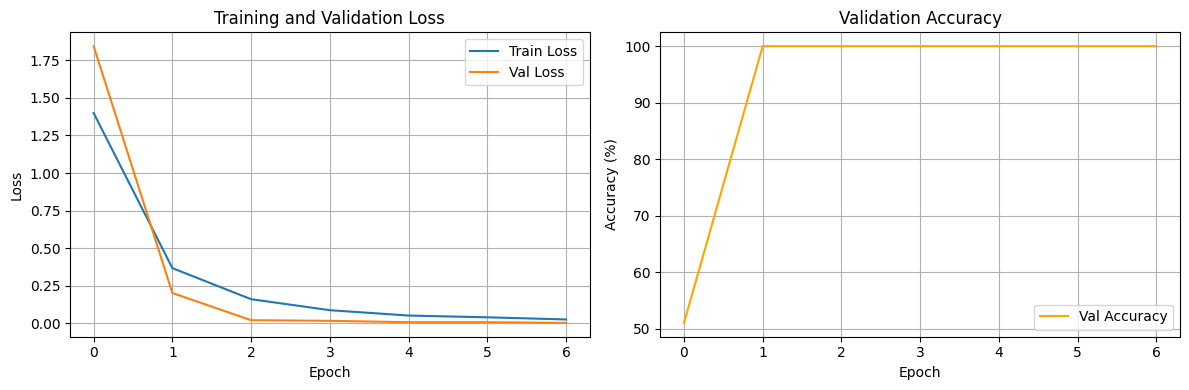


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00        10
          10       1.00      1.00      1.00        10
          11       1.00      1.00      1.00        10
          12       1.00      1.00      1.00        10
          13       1.00      1.00      1.00        10
          14       1.00      1.00      1.00        10
          15       1.00      1.00      1.00        10
          16       1.00      1.00      1.00        10
          17       1.00      1.00      1.00        10
          18       1.00      1.00      1.00        10
          19       1.00      1.00      1.00        10
           2       1.00      1.00      1.00        10
           3       1.00      1.00      1.00        10
           4       1.00      1.00      1.00        10
           5       1.00      1.00      1.00        10
           6       1.00      1.00      1.00        10
   

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np
import cv2
import os
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import re

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

DATA_PATH = r"D:\Coding\Rohit_Coding_Materials\Video Action Recognition\Sign-Image\filtered_gesture_data"
IMG_SIZE = (64, 64)
BATCH_SIZE = 32
EPOCHS = 15  
LEARNING_RATE = 0.001
NUM_CLASSES = 20

class GestureDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = str(self.image_paths[idx])  
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        
        if image is None:
            image = np.zeros((IMG_SIZE[0], IMG_SIZE[1]), dtype=np.uint8)
            print(f"Warning: Could not load image {img_path}")
        
        if self.transform:
            image = self.transform(image)
        else:
            image = torch.from_numpy(image).float() / 255.0
            image = image.unsqueeze(0)  
            
        label = self.labels[idx]
        return image, label

def get_transforms():
    train_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(IMG_SIZE),
        transforms.RandomRotation(10),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])
    
    val_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])
    
    return train_transform, val_transform

def load_data(data_path):
    data_path = re.sub(r'[\x00-\x1f]', '', data_path)  
    data_dir = Path(data_path)
    
    if not data_dir.exists():
        raise FileNotFoundError(f"Data directory does not exist: {data_dir}")
    
    image_paths = []
    labels = []
    
    gesture_folders = sorted([f for f in data_dir.iterdir() if f.is_dir()])
    print(f"Found {len(gesture_folders)} gesture folders")
    
    for folder in gesture_folders:
        gesture_label = folder.name
        image_files = [f for f in folder.iterdir() if f.suffix.lower() in ['.jpg', '.jpeg', '.png', '.bmp']]
        print(f"Folder {gesture_label}: {len(image_files)} images")
        
        for img_file in image_files:
            image_paths.append(img_file)
            labels.append(gesture_label)
    
    if len(image_paths) == 0:
        raise ValueError("No images found in the data directory")
    
    le = LabelEncoder()
    encoded_labels = le.fit_transform(labels)
    
    return image_paths, encoded_labels, le

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs):
    train_losses = []
    val_losses = []
    val_accuracies = []
    best_val_acc = 0.0
    patience_counter = 0
    patience = 5  
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        train_correct = 0
        train_total = 0
        
        train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs} [Train]')
        for images, labels in train_pbar:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            
            train_pbar.set_postfix({
                'Loss': running_loss / train_total,
                'Acc': 100 * train_correct / train_total
            })
        
        train_loss = running_loss / len(train_loader.dataset)
        train_acc = 100 * train_correct / train_total
        train_losses.append(train_loss)
        
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            val_pbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{epochs} [Val]')
            for images, labels in val_pbar:
                images, labels = images.to(device), labels.to(device)
                
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
                
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                
                val_pbar.set_postfix({
                    'Loss': val_loss / val_total,
                    'Acc': 100 * val_correct / val_total
                })
        
        val_loss = val_loss / len(val_loader.dataset)
        val_acc = 100 * val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        
        scheduler.step(val_loss)
        print(f"Current LR: {optimizer.param_groups[0]['lr']}")  # Added for LR tracking
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            patience_counter += 1
            
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
            
        print(f'Epoch {epoch+1}/{epochs}: '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
    
    return train_losses, val_losses, val_accuracies

def plot_history(train_losses, val_losses, val_accuracies):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    ax1.plot(train_losses, label='Train Loss')
    ax1.plot(val_losses, label='Val Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    
    ax2.plot(val_accuracies, label='Val Accuracy', color='orange')
    ax2.set_title('Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()

def main():
    print("Loading and preparing data...")
    try:
        image_paths, labels, label_encoder = load_data(DATA_PATH)
        
        train_paths, val_paths, train_labels, val_labels = train_test_split(
            image_paths, labels, test_size=0.2, random_state=42, stratify=labels
        )
        
        print(f"Total images: {len(image_paths)}")
        print(f"Training images: {len(train_paths)}")
        print(f"Validation images: {len(val_paths)}")
        
        train_transform, val_transform = get_transforms()
        
        train_dataset = GestureDataset(train_paths, train_labels, train_transform)
        val_dataset = GestureDataset(val_paths, val_labels, val_transform)
        
        train_loader = DataLoader(
            train_dataset, 
            batch_size=BATCH_SIZE, 
            shuffle=True,
            num_workers=0,  
            pin_memory=True  
        )
        
        val_loader = DataLoader(
            val_dataset, 
            batch_size=BATCH_SIZE, 
            shuffle=False,
            num_workers=0,  
            pin_memory=True
        )
        
        model = GestureCNN(num_classes=NUM_CLASSES).to(device)
        
        total_params = sum(p.numel() for p in model.parameters())
        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        print(f"Total parameters: {total_params:,}")
        print(f"Trainable parameters: {trainable_params:,}")
        
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)
        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)  
        
        print("Starting training...")
        start_time = time.time()
        
        train_losses, val_losses, val_accuracies = train_model(
            model, train_loader, val_loader, criterion, optimizer, scheduler, EPOCHS
        )
        
        training_time = time.time() - start_time
        print(f"Training completed in {training_time:.2f} seconds")
        
        plot_history(train_losses, val_losses, val_accuracies)
        
        model.load_state_dict(torch.load('best_model.pth', map_location=device))  
        model.eval()
        
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        print("\nClassification Report:")
        print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))
        
        torch.save({
            'model_state_dict': model.state_dict(),
            'label_encoder': label_encoder,
            'img_size': IMG_SIZE
        }, 'gesture_recognition_model.pth')
        
        print("Model saved as 'gesture_recognition_model.pth'")
        
    except Exception as e:
        print(f"Error: {e}")
        print("Please check your data path and ensure the filtered_gesture_data folder exists")
        print(f"Current data path: {DATA_PATH}")

if __name__ == "__main__":
    main()

In [ ]:
import torch
import torch.nn as nn
import cv2
import numpy as np
from torchvision import transforms
from pathlib import Path
import pickle
from sklearn.preprocessing import LabelEncoder  
import torch.serialization  

torch.serialization.add_safe_globals([LabelEncoder])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

class GestureCNN(nn.Module):
    def __init__(self, num_classes=20):
        super(GestureCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout2d(0.25),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout2d(0.25),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout2d(0.25),
        )
        self.classifier = nn.Sequential(
            nn.Linear(128 * 8 * 8, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

def get_test_transform(img_size):
    return transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(img_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])

def predict_image(model, img_path, transform, label_encoder, device):
    img_path = str(Path(img_path))  
    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise ValueError(f"Failed to load image: {img_path}")
    
    image = transform(image).unsqueeze(0)  
    image = image.to(device)
    
    model.eval()
    with torch.no_grad():
        outputs = model(image)
        _, pred = torch.max(outputs, 1)
        pred_class_idx = pred.item()
        pred_class_name = label_encoder.inverse_transform([pred_class_idx])[0]
    
    return pred_class_name, pred_class_idx

def main():
    model_path = r"D:\Coding\Rohit_Coding_Materials\Video Action Recognition\best_model.pth"
    test_img_path = r"D:\Coding\Rohit_Coding_Materials\Video Action Recognition\Sign-Image\train\13\1.jpg"  
    num_classes = 20
    img_size = (64, 64)  
    
    try:
        from sklearn.preprocessing import LabelEncoder
        classes = [str(i) for i in range(20)]  
        label_encoder = LabelEncoder()
        label_encoder.fit(classes)
        
        model = GestureCNN(num_classes=num_classes).to(device)
        model.load_state_dict(torch.load(model_path, map_location=device))
        
        test_transform = get_test_transform(img_size)
        
        pred_class_name, pred_class_idx = predict_image(model, test_img_path, test_transform, label_encoder, device)
        print(f"Predicted class: {pred_class_name} (Index: {pred_class_idx})")
        
    except FileNotFoundError as e:
        print(f"Error: {e}. Check if {model_path} or {test_img_path} exists.")
    except Exception as e:
        print(f"Error during prediction: {e}")

if __name__ == "__main__":
    main()